### 设置MindSpore运行于图模式，硬件平台为CPU

In [1]:
from mindspore import context
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

### 定义训练样本生成函数

In [2]:
import numpy as np
np.random.seed(1101) # 指定随机数种子，产生相同的随机数，便于观察试验结果

def f(x, w=3.0, b=1.0): # 目标函数
    return x * w + b

def get_data(num):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 3)
        y = f(x) + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

### 生成训练样本并增强

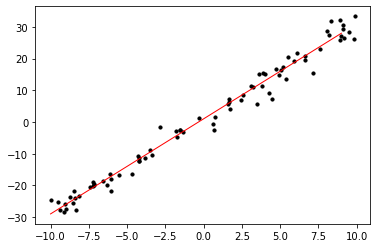

In [3]:
from mindspore import dataset as ds
import matplotlib.pyplot as plt

data_number = 80 # 样本总数
batch_size = 16 # 每批训练样本数（批梯度下降法）
repeat_size = 1

train_data = list(get_data(data_number))
X, y = zip(*train_data)
plt.scatter(X, y, color="black", s=10)
xx = np.arange(-10.0, 10, 1)
yy = f(xx)
plt.plot(xx, yy, color="red", linewidth=1, linestyle='-')
plt.show()

In [4]:
ds_train = ds.GeneratorDataset(train_data, column_names=['samples', 'label'])
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.repeat(repeat_size)

print("The dataset size of ds_train:", ds_train.get_dataset_size())
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["samples"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

The dataset size of ds_train: 5
dict_keys(['samples', 'label'])
The x label value shape: (16, 1)
The y label value shape: (16, 1)


### 定义代表线性回归模型的神经网络层

In [5]:
from mindspore.common.initializer import Normal
from mindspore import nn, Parameter
from mindspore.ops import operations as P
from mindspore.common.initializer import initializer

class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.matmul = P.MatMul()
        self.bias_add = P.BiasAdd()
        self.weight = Parameter(initializer('normal', shape=[1, 1]), name="weight")
        self.bias = Parameter(initializer('zero', shape=[1]), name="bias")

    def construct(self, x):
        x = self.matmul(x, self.weight)
        x = self.bias_add(x, self.bias)
        return x

net = LinearNet() # 实例化

# 查看模型参数初始值
model_params = net.trainable_params()
for param in model_params:
    print(param, param.asnumpy())

Parameter (name=weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[-0.00242984]]
Parameter (name=bias, shape=(1,), dtype=Float32, requires_grad=True) [0.]


In [6]:
from mindspore import Model

net_loss = nn.loss.MSELoss() # 定义损失函数
opt = nn.Momentum(net.trainable_params(), learning_rate=0.005, momentum=0.9) # 定义优化方法
model = Model(net, net_loss, opt) # 将网络结构、损失函数和优化方法进行关联

### 训练过程可视化函数

In [7]:
import time
from mindspore import Tensor

def plot_model_and_datasets(net, train_data):
    weight = net.trainable_params()[0]
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*train_data)
    x_target = x
    y_target = f(x_target)

    plt.axis([-11, 11, -20, 25])
    plt.scatter(x1, y1, color="black", s=10)
    plt.plot(x, y, color="blue", linestyle=':', linewidth=2)
    plt.plot(x_target, y_target, color="red")
    plt.show()
    time.sleep(0.02)
    
from IPython import display
from mindspore.train.callback import Callback

class ImageShowCallback(Callback): # 回调类
    def __init__(self, net, train_data):
        self.net = net
        self.train_data = train_data

    def step_end(self, run_context):
        plot_model_and_datasets(self.net, self.train_data)
        display.clear_output(wait=True)

### 开始训练并动态显示拟合过程

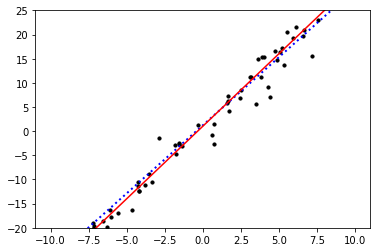

Parameter (name=weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[2.8172028]]
Parameter (name=bias, shape=(1,), dtype=Float32, requires_grad=True) [1.2027897]


In [8]:
epoch = 10
imageshow_cb = ImageShowCallback(net, train_data)
model.train(epoch, ds_train, callbacks=[imageshow_cb], dataset_sink_mode=False)

plot_model_and_datasets(net, train_data)
for param in net.trainable_params():
    print(param, param.asnumpy())

### ！！！新版本变化：MindSpore1.7.0已经在CPU平台上支持SGD算子，下面给出用SGD优化的示例

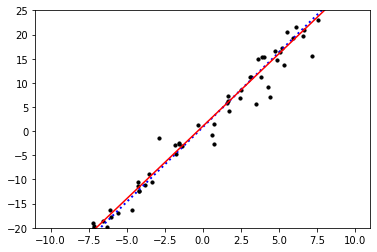

Parameter (name=weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[3.0952084]]
Parameter (name=bias, shape=(1,), dtype=Float32, requires_grad=True) [0.8197928]


In [9]:
opt_sgd = nn.SGD(net.trainable_params()) # 定义优化方法
ms_model = Model(net, net_loss, opt_sgd) # 将网络结构、损失函数和优化方法进行关联

ds_train1 = ds.GeneratorDataset(train_data, column_names=['samples', 'label'])
ds_train1 = ds_train1.batch(batch_size)
ds_train1 = ds_train1.repeat(repeat_size)

model.train(epoch, ds_train1, callbacks=[imageshow_cb], dataset_sink_mode=False)

plot_model_and_datasets(net, train_data)
for param in net.trainable_params():
    print(param, param.asnumpy())

### TensorFlow2版本

！！！新版本变化：TensorFlow2.0.0版本下的代码不能正常运行，报错ModuleNotFoundError: No module named 'keras'

In [12]:
#import tensorflow as tf
import tensorflow.keras as keras

# 自定义线性回归层
class LinearLayer(keras.layers.Layer):
    def __init__(self, inp_dim, outp_dim):
        super(LinearLayer, self).__init__()
        self.weight = self.add_variable('weight', [inp_dim, outp_dim], initializer=tf.random_normal_initializer())
        self.bias = self.add_variable('bias', [outp_dim], initializer=tf.zeros_initializer())
        
    def call(self, inputs, training = None):
        out = inputs * self.weight + self.bias
        return out
    
    def show_variable(self):
        print('weight:', self.weight)
        print('bias:', self.bias)
    
# 自定义线性回归模型
class LinearMode(keras.Model):
    def __init__(self):
        super(LinearMode, self).__init__()
        self.linearlayer = LinearLayer(1,1)
        
    def call(self, inputs, training = None):
        x = self.linearlayer(inputs)
        return x
    
    def show_v(self):
        self.linearlayer.show_variable()
        
linearmode = LinearMode()

linearmode.compile(optimizer='sgd', loss='mean_squared_error')

In [13]:
XX = np.array(X).reshape(-1)
yy = np.array(y).reshape(-1)
linearmode.fit(XX, yy, epochs=1000, verbose=1)
linearmode.show_v()

Epoch 1/1000
3/3 [==============================] - 1s 3ms/step - loss: 179.0206
Epoch 2/1000
3/3 [==============================] - 0s 11ms/step - loss: 7.2289
Epoch 3/1000
3/3 [==============================] - 0s 4ms/step - loss: 7.2003
Epoch 4/1000
3/3 [==============================] - 0s 7ms/step - loss: 7.1811
Epoch 5/1000
3/3 [==============================] - 0s 4ms/step - loss: 7.0573
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 7.0981
Epoch 7/1000
3/3 [==============================] - 0s 9ms/step - loss: 7.2018
Epoch 8/1000
3/3 [==============================] - 0s 6ms/step - loss: 7.1703
Epoch 9/1000
3/3 [==============================] - 0s 4ms/step - loss: 7.3969
Epoch 10/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.8905
Epoch 11/1000
3/3 [==============================] - 0s 3ms/step - loss: 7.0237
Epoch 12/1000
3/3 [==============================] - 0s 3ms/step - loss: 7.1235
Epoch 13/1000
3/3 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 6.8209
Epoch 205/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7736
Epoch 206/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7129
Epoch 207/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.9525
Epoch 208/1000
3/3 [==============================] - 0s 4ms/step - loss: 6.6380
Epoch 209/1000
3/3 [==============================] - 0s 3ms/step - loss: 7.0890
Epoch 210/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6677
Epoch 211/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.8971
Epoch 212/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.8777
Epoch 213/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.9827
Epoch 214/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7806
Epoch 215/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.8470
Epoch 216/1000
3/3 [=======================

3/3 [==============================] - 0s 2ms/step - loss: 6.6944
Epoch 407/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.7501
Epoch 408/1000
3/3 [==============================] - 0s 4ms/step - loss: 6.7275
Epoch 409/1000
3/3 [==============================] - 0s 4ms/step - loss: 6.6713
Epoch 410/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6510
Epoch 411/1000
3/3 [==============================] - 0s 11ms/step - loss: 7.0052
Epoch 412/1000
3/3 [==============================] - 0s 2ms/step - loss: 7.1284
Epoch 413/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.8976
Epoch 414/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.7864
Epoch 415/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.8715
Epoch 416/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6863
Epoch 417/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.9354
Epoch 418/1000
3/3 [======================

3/3 [==============================] - 0s 3ms/step - loss: 6.8224
Epoch 609/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.7085
Epoch 610/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7221
Epoch 611/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6304
Epoch 612/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7347
Epoch 613/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6152
Epoch 614/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.7044
Epoch 615/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6422
Epoch 616/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.6126
Epoch 617/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.6819
Epoch 618/1000
3/3 [==============================] - 0s 4ms/step - loss: 6.8977
Epoch 619/1000
3/3 [==============================] - 0s 2ms/step - loss: 7.1108
Epoch 620/1000
3/3 [=======================

3/3 [==============================] - 0s 2ms/step - loss: 6.6361
Epoch 811/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6505
Epoch 812/1000
3/3 [==============================] - 0s 4ms/step - loss: 7.0429
Epoch 813/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.8229
Epoch 814/1000
3/3 [==============================] - 0s 5ms/step - loss: 7.1962
Epoch 815/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.6334
Epoch 816/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7534
Epoch 817/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7123
Epoch 818/1000
3/3 [==============================] - 0s 3ms/step - loss: 7.8788
Epoch 819/1000
3/3 [==============================] - 0s 3ms/step - loss: 7.8406
Epoch 820/1000
3/3 [==============================] - 0s 2ms/step - loss: 6.6047
Epoch 821/1000
3/3 [==============================] - 0s 3ms/step - loss: 6.7297
Epoch 822/1000
3/3 [=======================